In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from concept_erasure import LeaceEraser

## Two classes

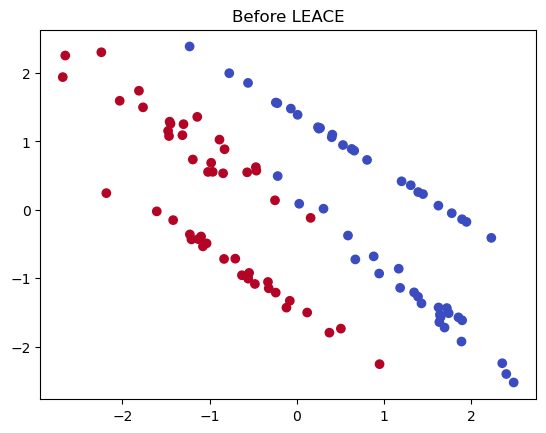

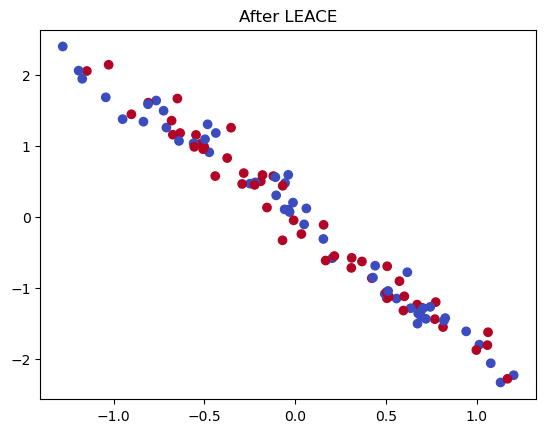

In [30]:
n, d, k = 100, 10, 2

X, Y = make_classification(
    n_samples=n,
    n_features=d,
    n_classes=k,
    random_state=42,
)
X_t = torch.from_numpy(X)
Y_t = torch.from_numpy(Y)

# Logistic regression does learn something before concept erasure
real_lr = LogisticRegression(max_iter=1000).fit(X, Y)
beta = torch.from_numpy(real_lr.coef_)
assert beta.norm(p=torch.inf) > 0.1

eraser = LeaceEraser.fit(X_t, Y_t)
X_ = eraser(X_t)

plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='coolwarm')
plt.title("Before LEACE")
plt.show()

plt.scatter(X_[:, 0], X_[:, 1], c=Y, cmap='coolwarm')
plt.title("After LEACE")
plt.show()

In [31]:
probe = LogisticRegression().fit(X, Y) 

acc_before = probe.score(X, Y)
print(f"Probe accuracy BEFORE LEACE (on test set): {acc_before:.2f}")

probe_after = LogisticRegression(max_iter=1000).fit(X_, Y)
acc_after = probe_after.score(X_, Y)
print(f"Probe accuracy AFTER LEACE (on test set): {acc_after:.2f}")

Probe accuracy BEFORE LEACE (on test set): 1.00
Probe accuracy AFTER LEACE (on test set): 0.50


## Three classes, erasing just one concept

In [114]:
n, d, k = 1000, 10, 3

# Create synthetic data
X, Y = make_classification(
    n_samples=n,      
    n_features=d,     
    n_classes=k,      
    n_informative=8,  # Number of features actually useful for classification
    n_clusters_per_class=2, 
    flip_y=0.1,       # Add some noise
    random_state=42,  
)

Z_concept = (Y==1).astype(int)

print(f"Original labels: {np.unique(Y)}")
print(f"New concept labels: {np.unique(Z_concept)}")


Original labels: [0 1 2]
New concept labels: [0 1]


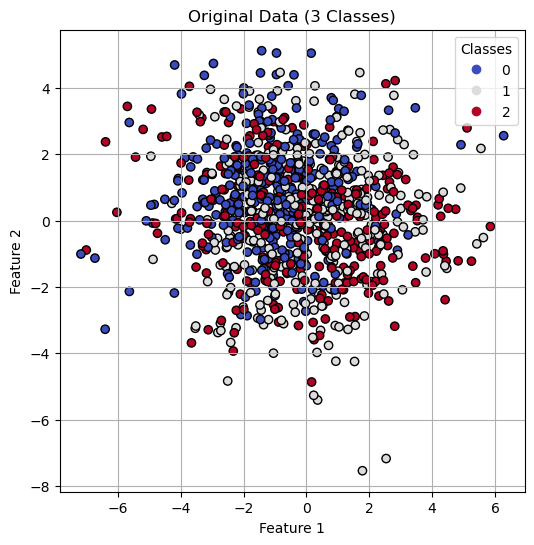

In [115]:
# Plot original data
plt.figure(figsize=(6,6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='coolwarm', edgecolors='k')
plt.title("Original Data (3 Classes)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.grid(True)
plt.show()


In [116]:
# Train a logistic regression probe to predict ONLY "is class 2?"
probe_concept_before = LogisticRegression(max_iter=1000).fit(X, Z_concept)
acc_concept_before = probe_concept_before.score(X, Z_concept)

print(f"Probe accuracy BEFORE LEACE (concept: is class 2?): {acc_concept_before:.2f}")

Probe accuracy BEFORE LEACE (concept: is class 2?): 0.76


In [117]:
# Convert to Torch if not already
X_t = torch.from_numpy(X).float()

# Fit LEACE to erase ONLY the concept "is class 2?"
eraser_concept = LeaceEraser.fit(X_t, torch.from_numpy(Z_concept))
X_concept_erased = eraser_concept(X_t)
X_concept_erased_np = X_concept_erased.numpy()


In [119]:
# Probe after LEACE
probe_concept_after = LogisticRegression(max_iter=1000).fit(X_concept_erased_np, Z_concept)
acc_concept_after = probe_concept_after.score(X_concept_erased_np, Z_concept)

print(f"Probe accuracy AFTER LEACE (concept: is class 2?): {acc_concept_after:.2f}")


Probe accuracy AFTER LEACE (concept: is class 2?): 0.66
